In [1]:
from dataclasses import asdict, dataclass

import torch
import wandb
from context_datasets import MetaLearningDataset
from control_function import ControlFunction, SetEncoder
from dvi_process import DIS
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import LambdaLR, StepLR
from torch.utils.data import DataLoader
from train import train
from metalearning_benchmarks.line_sine1d_benchmark import LineSine1D
from decoder import Decoder
from torch.distributions import Normal

In [2]:
import torch_directml

device =  torch.device("cpu") 
# device = torch_directml.device() 

In [3]:
@dataclass
class Config():
    num_steps = 16
    x_dim = 1
    y_dim = 1
    c_dim = 2
    z_dim = 2
    h_dim = 64
    num_layers = 4
    non_linearity = "SiLU"
    learning_rate = 3e-3
    batch_size = 512

config = Config()

In [4]:
benchmark = LineSine1D(
    n_task=4096,
    n_datapoints_per_task=64,
    output_noise=0.1,
    seed_task=1237, 
    seed_x=123, 
    seed_noise=1237
)

dataset = MetaLearningDataset(benchmark=benchmark)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 285845.22it/s]


In [5]:
set_encoder = SetEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    is_attentive=False,
    aggregation="mean",
    max_context_size=dataset.max_context_size
)

control_function = ControlFunction(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps,
    set_encoder=set_encoder
)

dvi_process = DIS(
    device=device, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control_function=control_function
).to(device)

decoder = Decoder(
    x_dim=config.x_dim,
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    y_dim=config.y_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity
).to(device)

In [6]:
target_constructor = lambda context: Normal(
    torch.zeros((config.batch_size, config.z_dim), device=device),
    torch.ones((config.batch_size, config.z_dim), device=device),
)

In [7]:
wandb_logging = True
if wandb_logging:
    wandb.init(project="dvi-bml", config=asdict(config))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [ ]:
num_epochs = 1000

optimizer = torch.optim.Adam(dvi_process.parameters(), lr=config.learning_rate * 0.1)
# scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.3 ) #1 if epoch < 1000 else 0.1)

In [9]:
losses = train(
    dvi_process=dvi_process, 
    device=device, 
    num_epochs=num_epochs,
    dataloader=dataloader, 
    target_constructor=target_constructor,
    optimizer=optimizer, 
    scheduler=None,
    wandb_logging=wandb_logging,
    decoder=decoder
)

100%|██████████| 8/8 [00:00<00:00,  8.64it/s, epoch=999, loss=49.2]


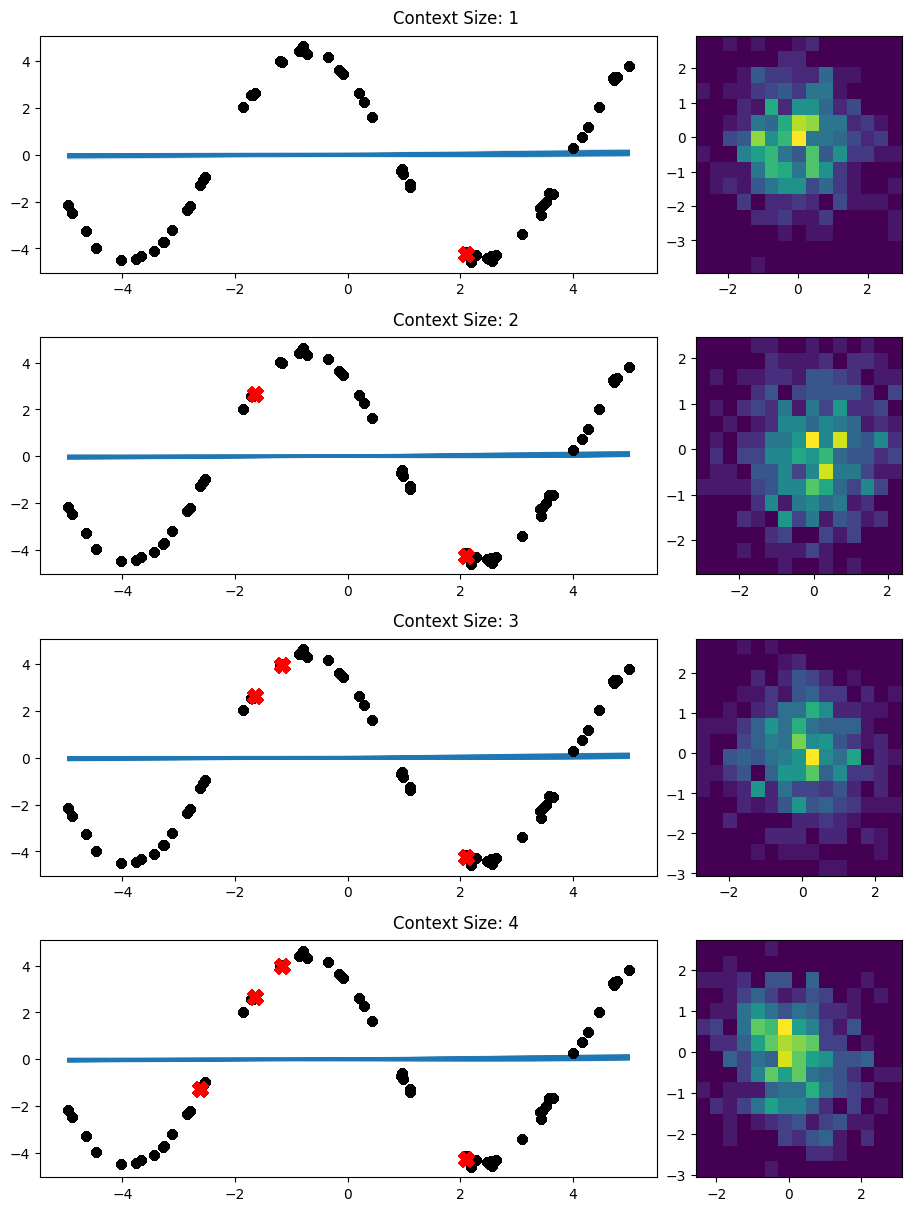

In [17]:
from torch.distributions import Distribution

gen_dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

max_context_size = 4
num_samples = config.batch_size

x_data, y_data = next(iter(gen_dataloader))
x_data, y_data = x_data.to(device), y_data.to(device)
x_data, y_data = x_data.repeat(num_samples, 1, 1), y_data.repeat(num_samples, 1, 1)

x_data_sorted, indices = x_data.sort(dim=1)
indices = indices[1].squeeze(1)
x_data_sorted = x_data_sorted.cpu().detach().numpy()
y_data_sorted = y_data[:, indices, :].cpu().detach().numpy()

fig = plt.figure(figsize=(9, 3 * max_context_size), constrained_layout=True)
subfigs = fig.subfigures(nrows=max_context_size, ncols=1)

for row, subfig in enumerate(subfigs):
    subfig.suptitle(f"Context Size: {row + 1}")
    ax = subfig.subplots(nrows=1, ncols=2, width_ratios=[3, 1])

    context_size = row + 1
    x_context = x_data[:, :context_size, :]
    y_context = y_data[:, :context_size, :]
    context = torch.cat([x_context, y_context], dim=-1)

    p_z_T = target_constructor(context)

    dvi_process.eval()
    with torch.no_grad():

        _, z_samples = dvi_process.run_chain(p_z_T, context)
        y_dist: Distribution = decoder(x_data, z_samples[-1])

    y_mu_sorted = y_dist.mean[:, indices, :].cpu().detach().numpy()

    for k in range(num_samples):
        ax[0].plot(x_data_sorted[k].squeeze(1), y_mu_sorted[k].squeeze(1), alpha=0.2, c="tab:blue", zorder=0)

    ax[0].scatter(x_data_sorted, y_data_sorted, marker="o", c="black", zorder=1)
    ax[0].scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="X", c="red", s=100, zorder=2)

    ax[1].hist2d(z_samples[-1][:, 0].cpu().detach().numpy(), z_samples[-1][:, 1].cpu().detach().numpy(), bins=15)

plt.show()